In [1]:
from data_processing import prepare_dataset, assign_colors
from align_func import execute_global_registration, icp_registration, colored_icp, obtain_registration_metrics, map_source2target
from GA import *
import pandas as pd
import numpy as np
import glob
import open3d as o3d
import matplotlib.pyplot as plt
import copy

In [2]:
parameters = {"voxel_size" : 10,
             "ransac_dist_modifier" : 1.5,
             "ransac_edge_length": 0.9,
             "downsample" : False,
             "voxel_radius" : [30, 20, 10] ,
             "max_iter": [50, 30, 14]}

In [3]:
positions_names = glob.glob("./datasets/xyz*.xls")
positions_list = [pd.read_excel(file, skiprows = [0,1,2], header = 0, usecols = [0,1,2]) 
                  for file in positions_names]
sox2_names = glob.glob("./datasets/sox2*.xls")
sox2_list = [pd.read_excel(file, skiprows = [0,1,2], header = 0, usecols = [0]) 
             for file in sox2_names]
sox2_source =sox2_list[0].to_numpy(dtype='float64')
sox2_target =sox2_list[1].to_numpy(dtype='float64')

In [4]:
source, target, source_processed, target_processed, source_fpfh, target_fpfh = prepare_dataset(positions_list, positions_names, voxel_size = 10, downsampling=False,norm_radius_modifier=2,norm_maxnn=30,fpfh_radius_modifier=5,fpfh_maxnn=100)

:: Point Cloud was not downsampled
:: Estimate normal with search radius 20.
:: Compute FPFH feature with search radius 50.
:: Point Cloud was not downsampled
:: Estimate normal with search radius 20.
:: Compute FPFH feature with search radius 50.


In [5]:
source

geometry::PointCloud with 2363 points.

In [6]:
assign_colors(source,target,sox2_list,"viridis")

:: Assigned colors to point clouds


NameError: name 'draw_scatter_pcd' is not defined

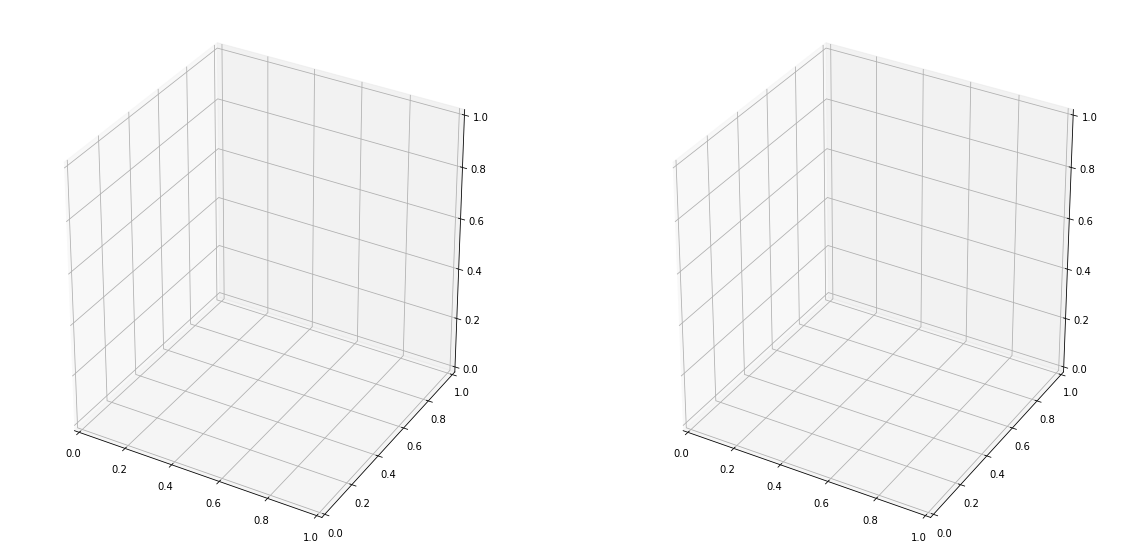

In [7]:
fig = plt.figure(figsize = (20,10))
ax0 = fig.add_subplot(121, projection='3d')
ax1= fig.add_subplot(122, projection='3d')
axes = [ax0, ax1]
pcd_list = [source, target]

for ax,pcd in zip(axes, pcd_list):
    draw_scatter_pcd(pcd = pcd, ax=ax, alpha = 0.7)

In [9]:
result_ransac = execute_global_registration(source_processed, target_processed,
                                            source_fpfh, target_fpfh,
                                            parameters["voxel_size"], parameters["ransac_dist_modifier"],
                                            parameters["ransac_edge_length"])
source_aligned_ransac = copy.deepcopy(source_processed)
source_aligned_ransac.transform(result_ransac.transformation)

:: RANSAC registration on point clouds.
   Since the  voxel size is 10.000,
   we use a liberal distance threshold 15.000.


geometry::PointCloud with 2363 points.

In [10]:
result_icp = icp_registration(source_processed, target_processed, source_fpfh, target_fpfh, 
                              result_ransac.transformation, parameters["voxel_size"])

source_aligned_icp= copy.deepcopy(source_processed)
source_aligned_icp.transform(result_icp.transformation)

geometry::PointCloud with 2363 points.

NameError: name 'label' is not defined

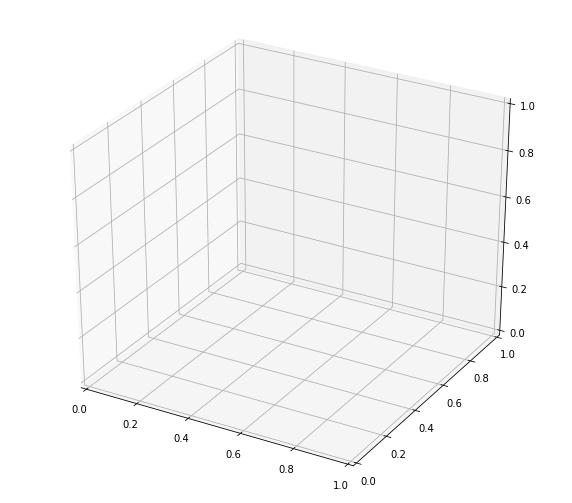

In [11]:
## Visualise globally registered point cloud with processed target
fig = plt.figure(figsize = (10,9))
ax = fig.add_subplot(111, projection='3d')
axes = [ax, ax]
color_list = ['k', 'r']
pcd_list = [np.asarray(target_processed.points), np.asarray(source_aligned_ransac.points)]


for ax,pcd,color in zip(axes, pcd_list,color_list):
    ax.scatter(xs = pcd[:,0], ys = pcd[:,1], zs = pcd[:,2], color = color, label = label)

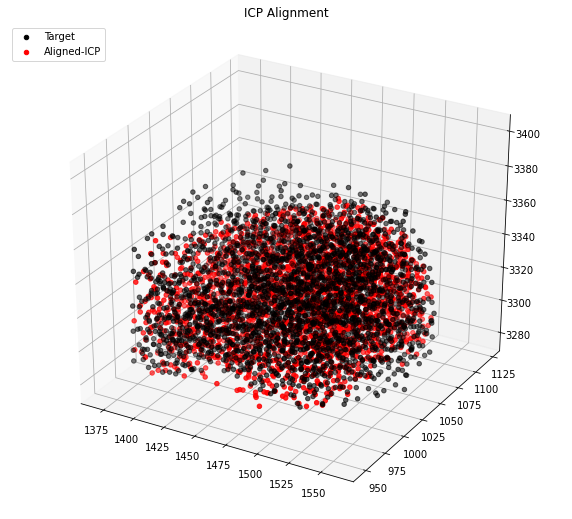

In [12]:
fig = plt.figure(figsize = (10,9))
ax = fig.add_subplot(111, projection='3d')
axes = [ax, ax]
color_list = ['k', 'r']
pcd_list = [np.asarray(target_processed.points), np.asarray(source_aligned_icp.points)]
label_list = ["Target", "Aligned-ICP"]



for ax,pcd,color,label in zip(axes, pcd_list,color_list, label_list):
    ax.scatter(xs = pcd[:,0], ys = pcd[:,1], zs = pcd[:,2], color = color, label = label)
    
ax.legend(loc='upper left')
ax.title.set_text('ICP Alignment')

In [13]:
result_icp_colored = colored_icp(source, target, result_ransac.transformation, parameters["voxel_radius"],  parameters["max_iter"], parameters["downsample"])
source_aligned_coloredICP= copy.deepcopy(source)
source_aligned_coloredICP.transform(result_icp_colored.transformation)
    

-- colored point cloud registration round 1 / 3 -- 
[50, 30, 0]
3-2. Estimate normal.
3-3. Applying colored point cloud registration
-- colored point cloud registration round 2 / 3 -- 
[30, 20, 1]
3-2. Estimate normal.
3-3. Applying colored point cloud registration
-- colored point cloud registration round 3 / 3 -- 
[14, 10, 2]
3-2. Estimate normal.
3-3. Applying colored point cloud registration


geometry::PointCloud with 2363 points.

In [14]:
result_icp_colored.transformation

array([[ 8.44517258e-01, -5.35341771e-01, -1.41347050e-02,
        -3.58132373e+03],
       [ 5.34421470e-01,  8.44174244e-01, -4.19944994e-02,
        -1.47956563e+03],
       [ 3.44135636e-02,  2.79111897e-02,  9.99017854e-01,
        -1.97628066e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

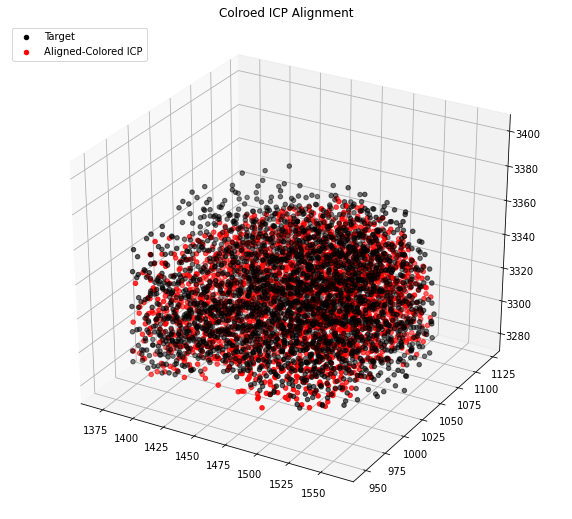

In [15]:
fig = plt.figure(figsize = (10,9))
ax = fig.add_subplot(111, projection='3d')
axes = [ax, ax]
color_list = ['k', 'r']
pcd_list = [np.asarray(target_processed.points), np.asarray(source_aligned_coloredICP.points)]
label_list = ["Target", "Aligned-Colored ICP"] 



for ax,pcd,color,label in zip(axes, pcd_list,color_list, label_list):
    ax.scatter(xs = pcd[:,0], ys = pcd[:,1], zs = pcd[:,2], color = color, label = label)
    
ax.legend(loc='upper left')
ax.title.set_text('Colroed ICP Alignment')



In [16]:
mae = calculate_mae(sox2_source, sox2_target, result_icp_colored)
print(mae)

9.979319853678993


In [17]:
obtain_registration_metrics(target, sox2_source, sox2_target, result_icp_colored)

--- Registration results --- 
Fitness: 99.28%
Inlier RMSE: 4.5447765565025415
MAE: 9.98
---------------------------------------
--- Correspondence map properties --- 
1212 (42.113%) unmapped targets.
553 (19.215%) targets that are mapped by multiple source points.
1113 (38.673%) targets that are uniquely mapped by a single source point.
All 2878 are accounted for.


In [18]:
target_new, mapped_range = map_source2target(source, target, sox2_source, sox2_target, result_icp_colored, method = "median", verbose = True)

Using median averaging
before assignment [[0.276194 0.190074 0.493001]
 [0.281412 0.155834 0.469201]
 [0.283197 0.11568  0.436115]
 ...
 [0.271305 0.019942 0.347269]
 [0.267004 0.004874 0.329415]
 [0.274952 0.037752 0.364543]]
after assignment [[0.277134 0.185228 0.489898]
 [0.267004 0.004874 0.329415]
 [0.267004 0.004874 0.329415]
 ...
 [0.267004 0.004874 0.329415]
 [0.267004 0.004874 0.329415]
 [0.267004 0.004874 0.329415]]
True


In [19]:
mapped_range